In [7]:
from grammar_ru.training.amenities import TRAINING_RESULTS, ResultPickleReader
from yo_fluq_ds import *
from grammar_ru import DfViewer
from IPython.display import HTML
from grammar_ru.training.amenities import Corpus, Loc




id = '20210620_113048_REP-LR10-NT10-_0127560c97824c2185c4260f77ee90f4'

res = ResultPickleReader(TRAINING_RESULTS/id)



Проблемы с корпусом:

* Шизофазия ('Борис Порумб')
* Тексты не на русском (153c53bf-9e70-4fa3-93cf-93e399305494)

<AxesSubplot:xlabel='iteration'>

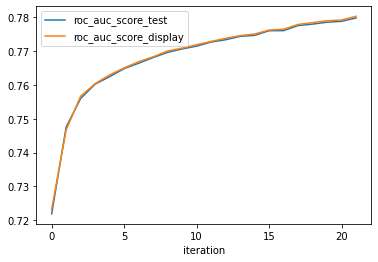

In [2]:
hdf = FileIO.read_pickle(res.get_path('output/history'))
hdf = pd.DataFrame(hdf).set_index('iteration')
hdf.drop('loss',axis=1).plot()

<AxesSubplot:xlabel='label', ylabel='predicted'>

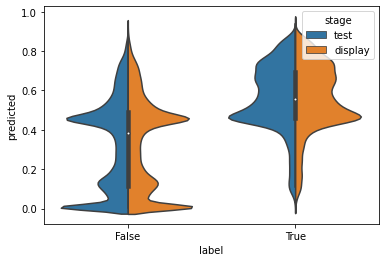

In [63]:
from seaborn import violinplot
ydf = FileIO.read_pickle(res.get_path('output/result_df'))
violinplot(data=ydf, x='label', y='predicted',split=True, hue='stage')

In [76]:
rdf = pd.read_parquet(Loc.bundles_path/'repetitions/bundle/src.parquet', columns=['word','word_type'])
df = ydf.merge(rdf, left_on='word_id', right_index=True)
df['word'] = df.word.str.lower()

<AxesSubplot:xlabel='label', ylabel='predicted'>

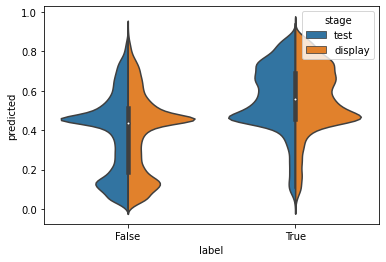

In [77]:
filter_words = ['-','--','---','появились']
df = df.loc[~df.word.isin(filter_words)]
violinplot(data=df, x='label', y='predicted',split=True, hue='stage')

In [84]:
gdf = df.groupby('file_id').size().sort_values().to_frame('inc')
tocs= Corpus.get_tocs()
gdf = gdf.merge(tocs,left_index=True, right_index=True)
gdf.inc=gdf.inc/gdf.token_count
gdf.sort_values('inc',ascending=False)
gdf.loc[gdf.header_4!='Борис Порумб']

,inc,filename,timestamp,part_index,token_count,character_count,ordinal,header_0,headers,source,...,author,serie,serie_index,max_id,header_1,header_2,header_3,header_4,header_5,month
file_id,,,,,,,,,,,,,,,,,,,,,
8f55550e-9388-413f-818a-7724dc6b187c,0.056818,books/fantasy/en/Мартин-ПЛИО-4.md,2021-06-15 13:01:01.108069,0,88,403,0,Джордж Мартин / Пир стервятников,Джордж Мартин / Пир стервятников,books,...,Мартин,ПЛИО,4,87,None,None,None,NaN,NaN,NaN
153c53bf-9e70-4fa3-93cf-93e399305494,0.003617,proza/fantasy/2021_04.md,2021-06-15 18:55:45.557845,433,18801,66172,5618,2021,2021 / 04 / 22 / 440 / Чума Баламут / Библиогр...,proza,...,NaN,NaN,NaN,80885821,04,22,440,Чума Баламут,Библиография. Неизвестная история человечества,2021_04
6e9bc4f9-7e7a-41a0-a30b-c787619dc1a5,0.012849,proza/fantasy/2019_09.md,2021-06-15 19:06:16.972271,35,11207,55419,6953,2019,2019 / 09 / 14 / 816 / Дядя Вова / Пропавшие в...,proza,...,NaN,NaN,NaN,99994699,09,14,816,Дядя Вова,Пропавшие в Средиземье часть 8,2019_09
7097dd9d-e5f3-4873-b900-aa3f89453a9f,0.013013,proza/fantasy/2018_04.md,2021-06-15 19:11:47.669347,149,11373,51296,7810,2018,2018 / 04 / 30 / 2002 / Кай Имланд / Дар богини,proza,...,NaN,NaN,NaN,113022868,04,30,2002,Кай Имланд,Дар богини,2018_04
e3f96928-8c67-404a-9337-220a53adda95,0.014159,proza/fantasy/2020_08.md,2021-06-15 19:34:46.432258,298,11018,55785,11206,2020,2020 / 08 / 13 / 836 / Дядя Вова / Пропавшие в...,proza,...,NaN,NaN,NaN,163224831,08,13,836,Дядя Вова,Пропавшие в Средиземье часть 10,2020_08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cdde68f9-73c0-4869-825e-b15ea5f88c21,0.023207,proza/fantasy/2020_11.md,2021-06-15 19:20:25.518168,36,361145,1547996,8904,2020,2020 / 11 / 02 / 399 / Юлия Пушкарева / Осинов...,proza,...,NaN,NaN,NaN,129399548,11,02,399,Юлия Пушкарева,Осиновая корона,2020_11
fdc34086-f911-4691-a051-9d0a07834112,0.039234,proza/fantasy/2019_05.md,2021-06-15 18:51:08.855946,165,215402,921802,5133,2019,2019 / 05 / 31 / 95 / Ярослав Овчаренко / Волш...,proza,...,NaN,NaN,NaN,73986911,05,31,95,Ярослав Овчаренко,Волшебник изумрудного города,2019_05
6c829dd1-257f-4804-868d-0e4a88fc14a4,0.068879,proza/fantasy/2020_06.md,2021-06-15 19:38:34.580123,185,126135,599178,12119,2020 / 2020,2020 / 2020 / 06 / 21 / 1591 / Антон Денисов 2...,proza,...,NaN,NaN,NaN,176389325,06,21,1591,Антон Денисов 2,В предверьях,2020_06


In [85]:
#df.loc[df.file_id=='153c53bf-9e70-4fa3-93cf-93e399305494']

In [89]:
class SampleBuilder:
    def __init__(self, df):
        self.df = df
        
    @staticmethod
    def merge_sentences(tdf, idf):
        idf = idf.loc[idf.file_id==tdf.file_id.iloc[0]]
        idf = idf.set_index('sentence_id')[['sample_id']]
        tdf = tdf.merge(idf, left_on='sentence_id',right_index=True)
        return tdf

    def build_sample_table(self):
        idf = (Query
           .df(self.df)
           .select_many(lambda row: Query
                        .en(range(row.another_sentence_id,row.sentence_id+1))
                        .select(lambda y:dict(sample_id=row['word_id'], file_id=row['file_id'], sentence_id=y)))
           .to_dataframe()
          )



        tdf = (Corpus
               .get_frames(lambda z: z.index.isin(idf.file_id))
               .select(lambda tdf: SampleBuilder.merge_sentences(tdf,idf))
               .feed(lambda z: pd.concat(list(z)))
              )
        tdf = tdf.merge(df[['another_word_id']], left_on='sample_id', right_index=True)
        tdf['highlight'] = (tdf.word_id==tdf.sample_id) | (tdf.word_id==tdf.another_word_id)
        return tdf

    def build_html(self):
        tdf = self.build_sample_table()
        result = []
        for id in tdf.sample_id.unique():
            result.append(DfViewer(highlight_column='highlight', as_html_object = False).convert(tdf.loc[tdf.sample_id==id]))

        return HTML('<br><br>'.join(result))

fdf = df.loc[(df.stage=='test') & df.label].sort_values('predicted')
SampleBuilder(fdf.iloc[:50]).build_html()